In [98]:
################### LER A IMAGEM DE LUZ NOTURNA ####################
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os.path
import os

########### ABRIR ARQUIVO RASTER ###############################################

######## É PRECISO QUE A PROJEÇÃO ESTEJA EM UTM ###################

img = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/luz_noturna/nighttime_CAMETA_2013_31982.tif'

ds = gdal.Open(img)
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

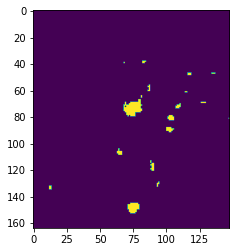

In [99]:
plt.imshow(array > 0.5)

<AxesSubplot:>

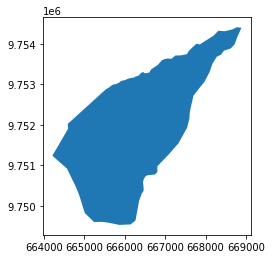

In [105]:
########## ABRIR ARQUIVO SHP DOS SETORES #######################################
sc_urb = 'D:/INPE_DISCIPLINAS/Dissertacao/shapes/setor_censitario/sc_2010_periurb_proposto.shp'

area_urb = gpd.read_file(sc_urb)
area_urb = area_urb[area_urb['NM_MUNICIP'] == 'CAMETÁ']
area_urb = area_urb[area_urb['situacaoNu']== 11].to_crs(31982).dissolve()
area_urb.plot()

In [109]:
########################### MODIFICAR PARA OS DESTINOS ESPECÍFICOS DESEJADOS #################################################
a = 'False'
limiar = 0.4    # limiar inicial a ser utilizado na imagem                                                                   #
limiarizado = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/luz_noturna/limiares/teste_CAMETA2013.tif'  # local do arquivo limiarizado.tif     #
out_path = 'D:/INPE_DISCIPLINAS/Dissertacao/shapes/luz_noturna/teste_CAMETA2013.shp' # LOCAL SHP LIMIARIZADO
bloco_notas = 'D:/INPE_DISCIPLINAS/Dissertacao/tabelas/limiares_CAMETA_2013.txt'  # local armazenado os valores de limiares testados #

In [110]:
while 'False' in a:
    ####################### EXPORTANDO O RASTER LIMIARIZADO ######################
    '''
    NESSA PARTE USA O LIMIARIZADO E O LIMIAR
    '''
    print('teste limiar: ', limiar)
    classificacao = array > limiar

    if os.path.exists(limiarizado):
        os.remove(limiarizado) 
        
    driver = gdal.GetDriverByName('GTiff')
    driver.Register()

    outds = driver.Create(limiarizado, xsize=classificacao.shape[1],
                     ysize = classificacao.shape[0],
                     bands = 1,
                     eType = gdal.GDT_Float32)

    outds.SetGeoTransform(gt)
    outds.SetProjection(proj)
    outband = outds.GetRasterBand(1)
    outband.WriteArray(classificacao)
    outband.SetNoDataValue(np.nan)
    outband.FlushCache()

    outband = None
    outds = None
     
    ######################## CONVERTER RASTER LIMIARIZADO PARA VETOR ####################
    '''
    NESSA PARTE USA O LIMIARIZADO (TIF) E O OUT_PATH (SHP)
    '''
    if os.path.exists(out_path):
            os.remove(out_path)

    #  get raster datasource
    src_ds = gdal.Open( limiarizado )
    #
    srcband = src_ds.GetRasterBand(1)
    dst_layername = 'teste_str2013'
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource( out_path )

    sp_ref = osr.SpatialReference()
    sp_ref.SetFromUserInput('EPSG:31982')

    dst_layer = dst_ds.CreateLayer(dst_layername, srs = sp_ref )

    fld = ogr.FieldDefn("Value", ogr.OFTInteger)
    dst_layer.CreateField(fld)
    dst_field = dst_layer.GetLayerDefn().GetFieldIndex("Value")

    gdal.Polygonize( srcband, None, dst_layer, dst_field, [], callback=None )

    del src_ds
    del dst_ds
    
    ###############  COMPARAR OS SHAPES DE LUZ NOTURNA COM AREA URBANA #########################
    '''
    NESSA PARTE USA O OUT_PATH (SHP) E A ÁREA URBANA JÁ DEFINIDA ANTERIORMENTE EM sc_urb E area_urb
    '''
    
    luz_not = gpd.read_file(out_path)

    # https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html
    reproj = luz_not.set_crs(epsg=31982)
    reproj = reproj[reproj['Value'] == 1].dissolve()
    
    a =  str(area_urb.within(reproj))

    with open (bloco_notas, 'a') as arquivo:
        arquivo.write(str(limiar) + ' ###### ' + str(a))
    
    limiar = limiar - 0.01

print('LIMIAR ENCONTRADO: ', str(limiar + 0.01))

teste limiar:  0.4
LIMIAR ENCONTRADO:  0.4


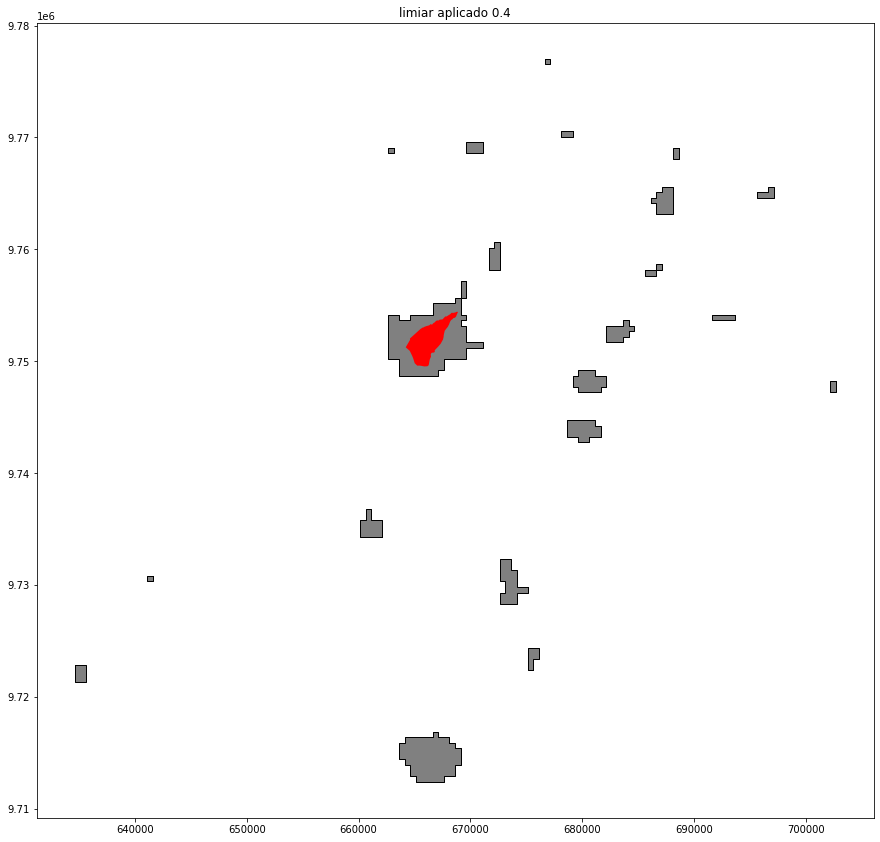

In [111]:
################### COMPARAR VETORES - SOBREPOSICAO #################
luz_not = gpd.read_file(out_path)

# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html
reproj = luz_not.set_crs(epsg=31982)
reproj = reproj[reproj['Value'] == 1].dissolve()

base = reproj.plot(color='grey', edgecolor='black', figsize=(15, 30))
base.set_title(f'limiar aplicado {limiar+ 0.01}')
area_urb.plot(ax=base, marker='o', color='red', markersize=5, figsize=(15, 30));

In [ ]:
'''  
esse é o código usado para exportar um numpy array como geotiff
retirado de: https://www.youtube.com/watch?v=p_BsFdV_LUk&t=434s
'''


# binmask = np.where( (array >= 0.5), 1, 0 )


limiarizado = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/luz_noturna/limiares/teste_str2013b.tif'

if os.path.exists(limiarizado):
        os.remove(limiarizado)

driver = gdal.GetDriverByName('GTiff')
driver.Register()

outds = driver.Create(limiarizado, xsize=binmask.shape[1],
                     ysize = binmask.shape[0],
                     bands = 1,
                     eType = gdal.GDT_Float32)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(binmask)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

outband = None
outds = None

In [35]:
'''  
esse é o código usado para transformar raster em vetor
retirado de: https://gis.stackexchange.com/questions/417383/how-to-apply-gdal-polygonize
'''

from osgeo import gdal, ogr, osr

in_path = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/luz_noturna/limiares/teste_str2013.tif'

out_path = 'D:/INPE_DISCIPLINAS/Dissertacao/shapes/luz_noturna/teste_str2013.shp'

if os.path.exists(out_path):
        os.remove(out_path)

#  get raster datasource
src_ds = gdal.Open( in_path )
#
srcband = src_ds.GetRasterBand(1)
dst_layername = 'teste_str2013'
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource( out_path )

sp_ref = osr.SpatialReference()
sp_ref.SetFromUserInput('EPSG:4674')

dst_layer = dst_ds.CreateLayer(dst_layername, srs = sp_ref )

fld = ogr.FieldDefn("Value", ogr.OFTInteger)
dst_layer.CreateField(fld)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex("Value")

gdal.Polygonize( srcband, None, dst_layer, dst_field, [], callback=None )

del src_ds
del dst_ds